In [2]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..', 'src'))  # ../src

In [3]:
from routing import TruckRouting
routing = TruckRouting(valhalla_url="http://192.168.0.72:8002", router_type="valhalla")

Loaded 52 US states for spatial analysis


In [5]:
traj = routing.generate_trajectory("New York", "Los Angeles")
traj['distance_km'], traj['duration_minutes'], len(traj['route_points'])

(4496.285, 2390, 2391)

In [4]:
trajectories = []
for i in range(100):
    start, end = routing.get_random_metro_pair()
    t = routing.generate_trajectory(start, end)
    t['id'] = i
    trajectories.append(t)
    if (i + 1) % 10 == 0:
        print(f"Completed: {i + 1}/100")

len(trajectories), trajectories[0].keys()

Completed: 10/100
Completed: 20/100
Completed: 30/100
Completed: 40/100
Completed: 50/100
Completed: 60/100
Completed: 70/100
Completed: 80/100
Completed: 90/100
Completed: 100/100


(100,
 dict_keys(['start_metro', 'end_metro', 'distance_km', 'duration_minutes', 'avg_speed_kmh', 'route_points', 'id']))

In [7]:
import pandas as pd, geopandas as gpd
rows = []
for t in trajectories:
    pts = t['route_points']
    for k in range(max(0, len(pts)-1)):
        lat1, lon1 = pts[k]; lat2, lon2 = pts[k+1]
        rows.append({'trajectory_id': t['id'], 'minute_idx': k,
                     'mid_lat': (lat1+lat2)/2.0, 'mid_lon': (lon1+lon2)/2.0})
df_segments = pd.DataFrame(rows)

points = gpd.GeoDataFrame(df_segments,
    geometry=gpd.points_from_xy(df_segments['mid_lon'], df_segments['mid_lat']),
    crs="EPSG:4326")
gdf = routing.states_gdf
col = 'STATE_NAME' if 'STATE_NAME' in gdf.columns else 'NAME'
joined = gpd.sjoin(points, gdf[[col,'geometry']], how='left', predicate='within')\
           .rename(columns={col:'STATE_NAME'}).drop(columns=['index_right'])
segments_with_state = pd.DataFrame(joined.drop(columns=['geometry']))
print("UNKNOWN segments:", segments_with_state['STATE_NAME'].isna().sum())

UNKNOWN segments: 95


In [8]:
states_gdf = routing.states_gdf.copy()
if states_gdf.crs is None:
    states_gdf.set_crs("EPSG:4326", inplace=True)
else:
    states_gdf = states_gdf.to_crs("EPSG:4326")


states_gdf["geometry"] = states_gdf.buffer(0)
state_col = "STATE_NAME" if "STATE_NAME" in states_gdf.columns else "NAME"

In [9]:
import geopandas as gpd

points_gdf = gpd.GeoDataFrame(
    df_segments,
    geometry=gpd.points_from_xy(df_segments["mid_lon"], df_segments["mid_lat"]),
    crs="EPSG:4326"
)

joined = gpd.sjoin(points_gdf, states_gdf[[state_col, "geometry"]],
                   how="left", predicate="intersects") \
         .rename(columns={state_col: "STATE_NAME"}) \
         .drop(columns=["index_right"])

segments_with_state = pd.DataFrame(joined.drop(columns=["geometry"]))
print("UNKNOWN after intersects:", segments_with_state["STATE_NAME"].isna().sum())

UNKNOWN after intersects: 95


In [13]:
# Reprojection to meters
states_m = states_gdf.to_crs(5070)        # NAD83 / Conus Albers
points_m = points_gdf.to_crs(5070)

# Only UNKNOWN
mask_unknown = segments_with_state["STATE_NAME"].isna()
unknown_points_m = points_m.loc[mask_unknown].copy()

# Nearest join with limit 10 km
nearest = gpd.sjoin_nearest(
    unknown_points_m,
    states_m[[state_col, "geometry"]],
    how="left", distance_col="dist_m"
).rename(columns={state_col: "STATE_NAME_NEAR"})

# dist_m <= 10000 m
fill = nearest.loc[nearest["dist_m"] <= 10_000, ["STATE_NAME_NEAR"]].reset_index()
segments_with_state.loc[mask_unknown, "STATE_NAME_NEAR"] = fill.set_index("index")["STATE_NAME_NEAR"]
segments_with_state["STATE_NAME"] = segments_with_state["STATE_NAME"].fillna(segments_with_state["STATE_NAME_NEAR"])
segments_with_state.drop(columns=["STATE_NAME_NEAR"], inplace=True, errors="ignore")

print("UNKNOWN after nearest<=10km:", segments_with_state["STATE_NAME"].isna().sum())

UNKNOWN after nearest<=10km: 0


In [10]:
state_minutes_per_truck = (
    segments_with_state.groupby(["trajectory_id","STATE_NAME"])
    .size().reset_index(name="minutes")
)
total_state_minutes = (
    state_minutes_per_truck.groupby("STATE_NAME")["minutes"]
    .sum().reset_index().sort_values("minutes", ascending=False)
)
total_minutes_all = int(total_state_minutes["minutes"].sum())
total_state_minutes["percentage"] = (total_state_minutes["minutes"]/total_minutes_all*100).round(2)
print(total_state_minutes.head(10))

      STATE_NAME  minutes  percentage
32      Virginia    14710       12.09
27  Pennsylvania    10728        8.82
30         Texas     9473        7.79
8        Florida     7550        6.21
4       Colorado     5692        4.68
29     Tennessee     5477        4.50
0        Alabama     5037        4.14
1        Arizona     3945        3.24
3     California     3889        3.20
5    Connecticut     3872        3.18


In [11]:
import os
out_dir = os.path.join('..','data','trajectories')
os.makedirs(out_dir, exist_ok=True)

segments_with_state.to_csv(os.path.join(out_dir, 'per_minute_segments_with_state.csv'), index=False)

state_minutes_per_truck.to_csv(os.path.join(out_dir, 'state_minutes_full.csv'), index=False)

total_state_minutes.to_csv(os.path.join(out_dir, 'state_minutes_summary.csv'), index=False)

print("Saved all CSV files to data/trajectories/")

Saved all CSV files to data/trajectories/


In [29]:
# Format: "California 456 minutes, Arizona 367 minutes, Texas 231 minutes"
print("=== FINAL RESULT: MINUTES PER STATE ===")
for _, row in total_state_minutes.head(10).iterrows():
    print(f"{row['STATE_NAME']}: {row['minutes']} minutes ({row['percentage']}%)")

print(f"\nTotal minutes: {total_minutes_all}")
print(f"Total trajectories: {len(trajectories)}")

=== FINAL RESULT: MINUTES PER STATE ===
Virginia: 14710 minutes (12.09%)
Pennsylvania: 10728 minutes (8.82%)
Texas: 9473 minutes (7.79%)
Florida: 7550 minutes (6.21%)
Colorado: 5692 minutes (4.68%)
Tennessee: 5477 minutes (4.5%)
Alabama: 5037 minutes (4.14%)
Arizona: 3945 minutes (3.24%)
California: 3889 minutes (3.2%)
Connecticut: 3872 minutes (3.18%)

Total minutes: 121675
Total trajectories: 100


In [30]:
import pandas as pd

df_summary = pd.DataFrame([{
    "id": t["id"],
    "start": t["start_metro"],
    "end": t["end_metro"],
    "distance_km": t["distance_km"],
    "duration_minutes": t["duration_minutes"],
    "avg_speed_kmh": t["distance_km"] / (t["duration_minutes"]/60) if t["duration_minutes"] > 0 else None,
} for t in trajectories])

print(df_summary.head())

   id              start          end  distance_km  duration_minutes  \
0   0  Dallas-Fort Worth      Atlanta     1266.466               686   
1   1            Houston     New York     2627.213              1452   
2   2       Philadelphia       Boston      493.399               316   
3   3           New York      Atlanta     1418.239               809   
4   4            Chicago  Los Angeles     3246.678              1693   

   avg_speed_kmh  
0     110.769621  
1     108.562521  
2      93.683354  
3     105.184598  
4     115.062422  


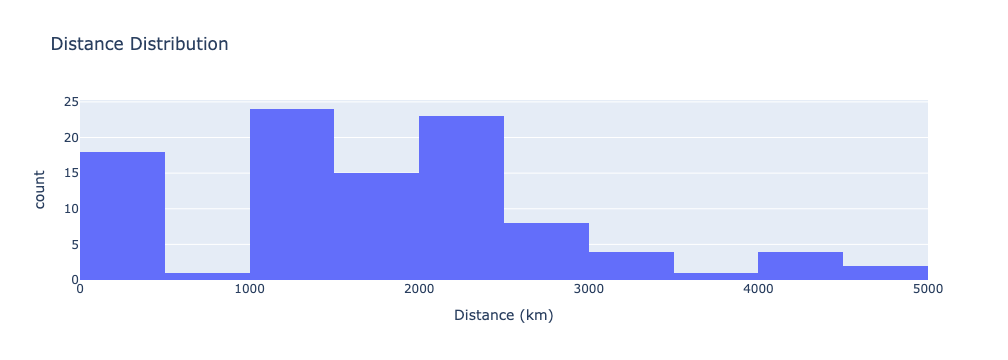

In [26]:
import plotly.express as px

fig = px.histogram(
    df_summary, 
    x='distance_km',
    nbins=20,
    title='Distance Distribution',
    labels={'distance_km': 'Distance (km)', 'count': 'Number of trajectories'}
)
fig.write_html('../data/plots/distance_histogram.html')
fig.show()

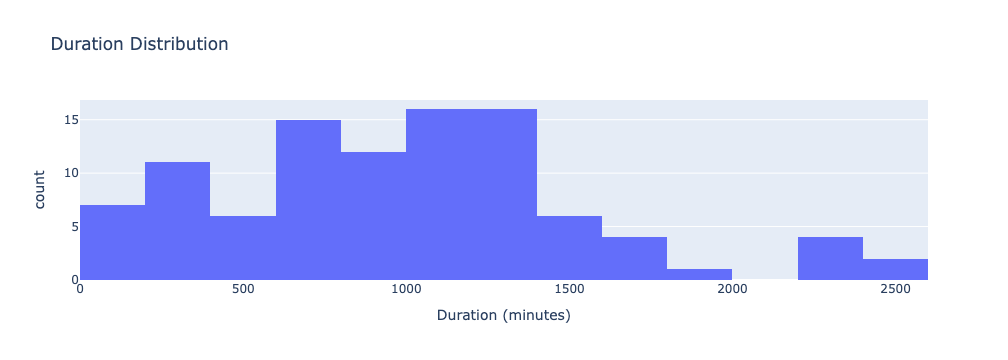

In [27]:
fig = px.histogram(
    df_summary, 
    x='duration_minutes',
    nbins=20,
    title='Duration Distribution',
    labels={'duration_minutes': 'Duration (minutes)', 'count': 'Number of trajectories'}
)
fig.write_html('../data/plots/duration_histogram.html')
fig.show()

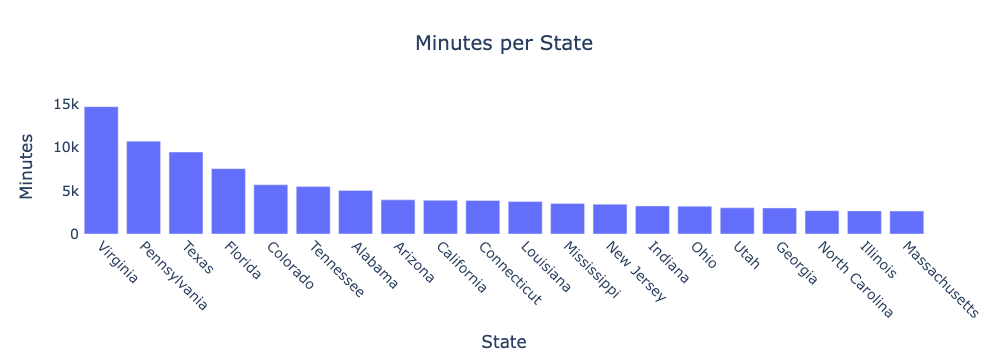

In [27]:
fig = px.bar(
    total_state_minutes.head(20), 
    x='STATE_NAME', 
    y='minutes',
    title='Minutes per State',
    labels={'STATE_NAME': 'State', 'minutes': 'Minutes'}
)
fig.update_xaxes(tickangle=45)

fig.update_layout(
    margin=dict(l=80, r=80, t=100, b=80),
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(size=14),
    title_x=0.5
)

fig.write_html('../data/plots/state_minutes_histogram.html')
fig.show()

In [32]:
corr = df_summary['distance_km'].corr(df_summary['duration_minutes'])
print(f'Correlation (distance vs duration): {corr:.3f}')

Correlation (distance vs duration): 0.998


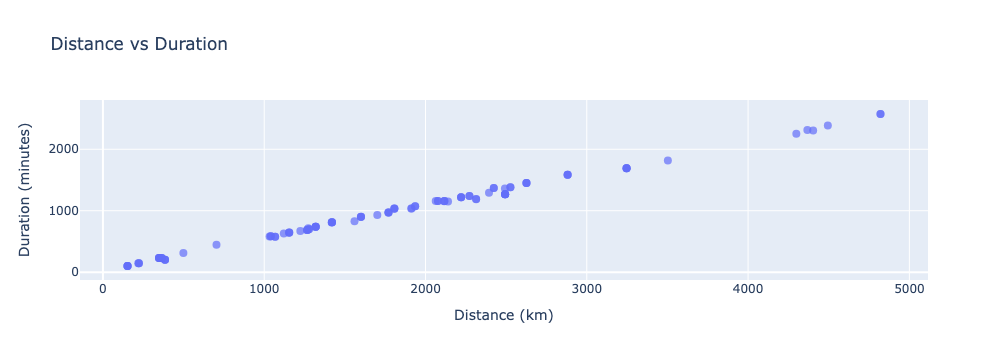

In [34]:
import plotly.express as px

fig = px.scatter(
    df_summary,
    x='distance_km', y='duration_minutes',
    hover_data=['start','end','avg_speed_kmh'],
    title='Distance vs Duration',
    labels={'distance_km':'Distance (km)', 'duration_minutes':'Duration (minutes)'}
)
fig.update_traces(marker=dict(size=8, opacity=0.7))
fig.write_html('../data/plots/distance_vs_duration.html')
fig.show()

In [15]:
import math

def haversine(lat1, lon1, lat2, lon2):
    """Calculate distance between two points in km"""
    R = 6371  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    return 2 * R * math.asin(math.sqrt(a))


distances = []
for t in trajectories:
    pts = t['route_points']
    for i in range(1, len(pts)):
        lat1, lon1 = pts[i-1]
        lat2, lon2 = pts[i]
        d_km = haversine(lat1, lon1, lat2, lon2)
        distances.append(d_km)

print("Distance per minute stats:")
print(f"Min: {min(distances):.3f} km")
print(f"Max: {max(distances):.3f} km")
print(f"Mean: {sum(distances)/len(distances):.3f} km")

Distance per minute stats:
Min: 0.025 km
Max: 21.418 km
Mean: 1.830 km


In [16]:
# Filter unreal distances (max 5 km per minute = 300 km/h)
realistic_distances = [d for d in distances if d <= 5.0]

print(f"Original: {len(distances)} segments")
print(f"Realistic: {len(realistic_distances)} segments")
print(f"Filtered out: {len(distances) - len(realistic_distances)} outliers")


print("\nRealistic distance stats:")
print(f"Min: {min(realistic_distances):.3f} km")
print(f"Max: {max(realistic_distances):.3f} km")
print(f"Mean: {sum(realistic_distances)/len(realistic_distances):.3f} km")

Original: 121770 segments
Realistic: 116205 segments
Filtered out: 5565 outliers

Realistic distance stats:
Min: 0.025 km
Max: 5.000 km
Mean: 1.588 km


In [17]:
# Generate speeds only for realistic distances
speeds = []
for t in trajectories:
    pts = t['route_points']
    for i in range(1, len(pts)):
        lat1, lon1 = pts[i-1]
        lat2, lon2 = pts[i]
        d_km = haversine(lat1, lon1, lat2, lon2)
        if d_km <= 5.0:  # Filter outliers
            speeds.append(d_km * 60)

print(f"Generated {len(speeds)} realistic speeds")
print(f"Speed range: {min(speeds):.1f} - {max(speeds):.1f} km/h")
print(f"Mean speed: {sum(speeds)/len(speeds):.1f} km/h")

Generated 116205 realistic speeds
Speed range: 1.5 - 300.0 km/h
Mean speed: 95.3 km/h


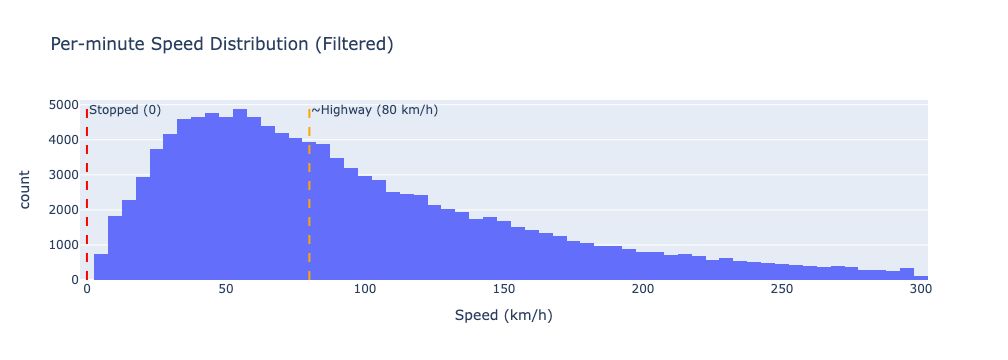

In [21]:
import plotly.express as px

fig = px.histogram(
    x=speeds, nbins=60,
    title='Per-minute Speed Distribution (Filtered)',
    labels={'x':'Speed (km/h)', 'count':'Frequency'}
)
fig.add_vline(x=0, line_dash="dash", line_color="red", annotation_text="Stopped (0)")
fig.add_vline(x=80, line_dash="dash", line_color="orange", annotation_text="~Highway (80 km/h)")
fig.write_html('../data/plots/speed_histogram.html')
fig.show()

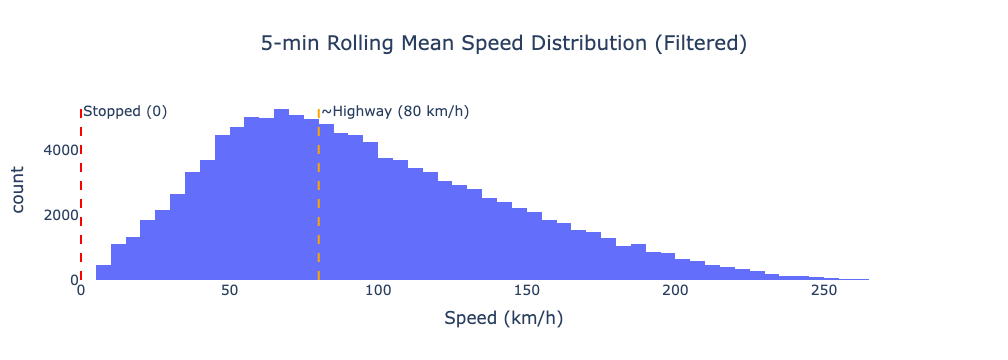

In [22]:
import pandas as pd
import plotly.express as px

# 5-min rolling mean with filtered speeds
rolling5 = pd.Series(speeds).rolling(window=5, center=True).mean().dropna()

fig = px.histogram(
    x=rolling5, nbins=60,
    title='5-min Rolling Mean Speed Distribution (Filtered)',
    labels={'x':'Speed (km/h)', 'count':'Frequency'}
)
fig.add_vline(x=0, line_dash="dash", line_color="red", annotation_text="Stopped (0)")
fig.add_vline(x=80, line_dash="dash", line_color="orange", annotation_text="~Highway (80 km/h)")

fig.update_layout(
    margin=dict(l=80, r=80, t=100, b=80),
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(size=14),
    title_x=0.5
)

fig.write_html('../data/plots/speed_histogram_rolling5.html')
fig.show()

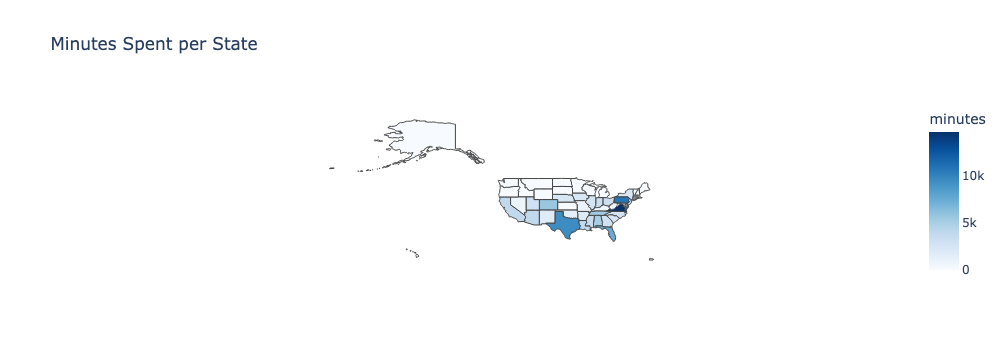

In [23]:
import geopandas as gpd
import pandas as pd

# 1) Read states and normalize column name
states_gdf = gpd.read_file('../data/us_states.geojson')

state_name_cols = ['STATE_NAME', 'NAME', 'name', 'state_name', 'state']
left_col = next((c for c in state_name_cols if c in states_gdf.columns), None)
assert left_col is not None, f"No column with state name in states_gdf: {states_gdf.columns.tolist()}"

states_gdf = states_gdf.rename(columns={left_col: 'STATE_NAME'})

# 2) Normalize right table (total_state_minutes)
right = total_state_minutes.copy()
right_name_cols = ['STATE_NAME', 'state', 'name']
right_col = next((c for c in right_name_cols if c in right.columns), None)
assert right_col is not None, f"No column with state name in total_state_minutes: {right.columns.tolist()}"

if right_col != 'STATE_NAME':
    right = right.rename(columns={right_col: 'STATE_NAME'})

# 3) Merge and fill NaN
merged = states_gdf.merge(right, on='STATE_NAME', how='left')
for col in ['minutes', 'percentage']:
    if col in merged.columns:
        merged[col] = merged[col].fillna(0)

# 4) Plotly choropleth
import plotly.express as px

fig = px.choropleth(
    merged,
    geojson=merged.geometry,
    locations=merged.index,
    color='minutes',
    hover_name='STATE_NAME',
    hover_data={'minutes':':,', 'percentage':':.2f'} if 'percentage' in merged.columns else ['STATE_NAME','minutes'],
    title='Minutes Spent per State',
    color_continuous_scale='Blues'
)
fig.update_geos(fitbounds="locations", visible=False)
fig.write_html('../data/plots/state_minutes_choropleth.html')
fig.show()

In [31]:
import math
import pandas as pd

def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1)*math.cos(lat2)*math.sin(dlon/2)**2
    return 2 * R * math.asin(math.sqrt(a))

# Build per-minute speed rows aligned (trajectory_id, minute_idx)
speed_rows = []
for t in trajectories:
    tid = t['id']
    pts = t['route_points']
    for i in range(max(0, len(pts) - 1)):
        lat1, lon1 = pts[i]
        lat2, lon2 = pts[i+1]
        d_km = haversine(lat1, lon1, lat2, lon2)
        speed_rows.append({
            'trajectory_id': tid,
            'minute_idx': i,
            'speed_kmh': d_km * 60.0
        })

df_speeds = pd.DataFrame(speed_rows)
print("Per-minute speeds:", len(df_speeds))
df_speeds.head()

Per-minute speeds: 121770


,trajectory_id,minute_idx,speed_kmh
0,0,0,8.936156
1,0,1,17.135118
2,0,2,16.847459
3,0,3,24.082083
4,0,4,32.477471


In [32]:
import numpy as np

merged_segments = segments_with_state.merge(
    df_speeds, on=['trajectory_id','minute_idx'], how='inner'
)

# Average speed per state
state_speed = (
    merged_segments
    .dropna(subset=['STATE_NAME'])
    .groupby('STATE_NAME')['speed_kmh']
    .mean()
    .reset_index(name='avg_speed_kmh')
)

# Color classification
def bucket_color(v):
    if v <= 1:          # ~stationary
        return 'red'
    elif v < 80:        # < 80 km/h ≈ < 50 mph
        return 'yellow'
    else:
        return 'green'

state_speed['color_bucket'] = state_speed['avg_speed_kmh'].apply(bucket_color)
print(state_speed.head(10))

             STATE_NAME  avg_speed_kmh color_bucket
0               Alabama     102.099564        green
1               Arizona     118.161168        green
2              Arkansas     159.057439        green
3            California     134.322412        green
4              Colorado      83.946174        green
5           Connecticut      53.704885       yellow
6              Delaware      67.418740       yellow
7  District of Columbia      25.202394       yellow
8               Florida     147.034576        green
9               Georgia     121.899645        green


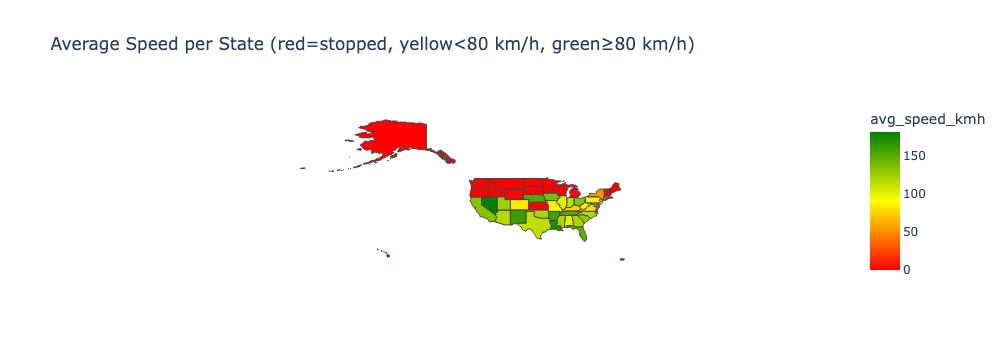

In [33]:
import geopandas as gpd
import plotly.express as px

states_gdf = gpd.read_file('../data/us_states.geojson')

state_name_cols = ['STATE_NAME', 'NAME', 'name', 'state_name', 'state']
left_col = next((c for c in state_name_cols if c in states_gdf.columns), None)
assert left_col is not None, f"No column with state name in states_gdf: {states_gdf.columns.tolist()}"

states_gdf = states_gdf.rename(columns={left_col: 'STATE_NAME'})

right = state_speed.copy()
right_name_cols = ['STATE_NAME', 'state', 'name']
right_col = next((c for c in right_name_cols if c in right.columns), None)
assert right_col is not None, f"No column with state name in state_speed: {right.columns.tolist()}"

if right_col != 'STATE_NAME':
    right = right.rename(columns={right_col: 'STATE_NAME'})

# 3) Merge and fill NaN
merged_speed = states_gdf.merge(right, on='STATE_NAME', how='left').fillna({'avg_speed_kmh':0})

# 4) Plotly choropleth
fig = px.choropleth(
    merged_speed,
    geojson=merged_speed.geometry,
    locations=merged_speed.index,
    color='avg_speed_kmh',
    hover_name='STATE_NAME',
    hover_data={'avg_speed_kmh':':.1f'},
    title='Average Speed per State (red=stopped, yellow<80 km/h, green≥80 km/h)',
    color_continuous_scale=['red','yellow','green'],
    range_color=(0, max(1.0, float(merged_speed['avg_speed_kmh'].max())))
)
fig.update_geos(fitbounds="locations", visible=False)
fig.write_html('../data/plots/state_avg_speed_choropleth.html')
fig.show()

In [34]:

df_summary.to_csv('../data/trajectories/trajectory_summary.csv', index=False)
print("Saved trajectory_summary.csv")

Saved trajectory_summary.csv


In [35]:

df_speeds.to_csv('../data/trajectories/per_minute_speeds.csv', index=False)
print("Saved per_minute_speeds.csv")

Saved per_minute_speeds.csv
